In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from tqdm import tqdm
from scipy.optimize import minimize
import scipy as sp
from scipy.integrate import solve_ivp
import numdifftools as nd

from numpy.linalg import eig

In [2]:
import os
if 'inference-from-testing' in os.getcwd():
    os.chdir("../..")
os.getcwd()

'/Users/user/Documents/GitHub/covid-19-in-households-public'

In [3]:
from copy import deepcopy
from numpy import array, log
from os import mkdir
from os.path import isdir, isfile
from pickle import load, dump
from pandas import read_csv
from scipy.integrate import solve_ivp
from model.preprocessing import ( estimate_beta_ext, estimate_growth_rate,
        SEIRInput, HouseholdPopulation, make_initial_condition_by_eigenvector)
from model.specs import TWO_AGE_SEIR_SPEC_FOR_FITTING, TWO_AGE_UK_SPEC
from model.common import SEIRRateEquations
from model.imports import NoImportModel

In [20]:
DOUBLING_TIME = 3
growth_rate = log(2) / DOUBLING_TIME

# List of observed household compositions
composition_list = read_csv(
    'inputs/eng_and_wales_adult_child_composition_list.csv',
    header=0).to_numpy()
# Proportion of households which are in each composition
comp_dist = read_csv(
    'inputs/eng_and_wales_adult_child_composition_dist.csv',
    header=0).to_numpy().squeeze()

if isdir('outputs') is False:
    mkdir('outputs')
if isdir('outputs/uk') is False:
    mkdir('outputs/uk')

SPEC = {**TWO_AGE_SEIR_SPEC_FOR_FITTING, **TWO_AGE_UK_SPEC}
model_input_to_fit = SEIRInput(SPEC, composition_list, comp_dist)
household_population_to_fit = HouseholdPopulation(
    composition_list, comp_dist, model_input_to_fit)
rhs_to_fit = SEIRRateEquations(model_input_to_fit, household_population_to_fit, NoImportModel(4,2))
beta_ext = estimate_beta_ext(household_population_to_fit, rhs_to_fit, growth_rate)
model_input = deepcopy(model_input_to_fit)
model_input.k_ext *= beta_ext
print('Estimated beta is',beta_ext)
with open('outputs/uk/fitted_SEIR_input.pkl', 'wb') as f:
    dump(model_input, f)


# With the parameters chosen, we calculate Q_int:
household_population = HouseholdPopulation(
    composition_list, comp_dist, model_input)

rhs = SEIRRateEquations(model_input, household_population, NoImportModel(4,2))

r_est = estimate_growth_rate(household_population, rhs, [0.001, 5], 1e-9)


print('Estimated growth rate is',r_est,'.')
print('Estimated doubling time is',log(2) / r_est,'.')

H0 = make_initial_condition_by_eigenvector(growth_rate, model_input, household_population, rhs, 1e-2, 0.0,False,3)
S0 = H0.T.dot(household_population.states[:, ::4])
E0 = H0.T.dot(household_population.states[:, 1::4])
I0 = H0.T.dot(household_population.states[:, 2::4])
R0 = H0.T.dot(household_population.states[:, 3::4])
start_state = (1/model_input.ave_hh_size) * array([S0.sum(),
                                                   E0.sum(),
                                                   I0.sum(),
                                                   R0.sum()])
tspan = (0.0, 365)
print(start_state)

Estimated beta_int= 0.020186608268488816 , estimated density= 0.5452972070936591
Estimated beta is [3.74338774]


/Users/user/Documents/GitHub/covid-19-in-households-public/model/preprocessing.py:1189: SparseEfficiencyWarning: spilu converted its input to CSC format
  sA_iLU = spilu(discount_matrix)


converged in 12 iterations.
Estimated growth rate is 0.23104906019420188 .
Estimated doubling time is 2.9999999999019242 .
[0.99 0.01 0.   0.  ]


In [25]:
# Now set up evaluation time points and solve system:

# New time at which we evaluate the infection
trange = np.arange(0,7*12,7) # Evaluate for 12 weeks

# Solve:
solution = solve_ivp(rhs, tspan, H0, first_step=0.001, atol=1e-16, t_eval=trange)

time = solution.t
H = solution.y
S = H.T.dot(household_population.states[:, ::4])
E = H.T.dot(household_population.states[:, 1::4])
I = H.T.dot(household_population.states[:, 2::4])
R = H.T.dot(household_population.states[:, 3::4])

/var/folders/mn/cjzm0gtn7_z4bsq7d44zp_y00000gp/T/ipykernel_66612/1082690048.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


Text(0.5, 1.0, 'Adults (20+ years old)')

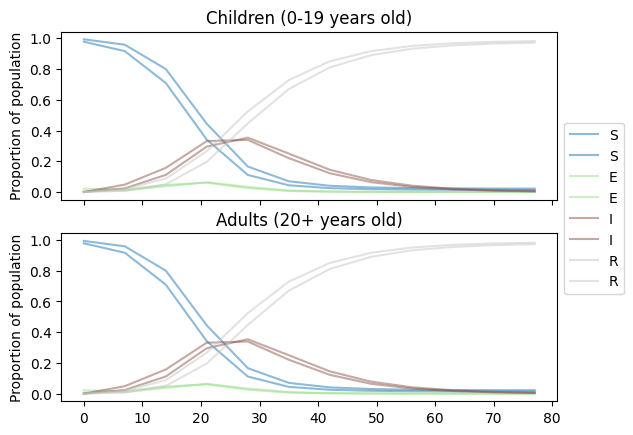

In [26]:
from matplotlib.pyplot import subplots
from matplotlib.cm import get_cmap

data_list = [S/model_input.ave_hh_by_class,
    E/model_input.ave_hh_by_class,
    I/model_input.ave_hh_by_class,
    R/model_input.ave_hh_by_class]

lgd=['S','E','I','R']

fig, (axis_C, axis_A) = subplots(2,1, sharex=True)

cmap = get_cmap('tab20')
alpha = 0.5
for i in range(len(data_list)):
    axis_C.plot(
        time, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis_C.set_ylabel('Proportion of population')
axis_C.set_title('Children (0-19 years old)')
axis_C.legend(ncol=1, bbox_to_anchor=(1,0.50))

for i in range(len(data_list)):
    axis_A.plot(
        time, data_list[i], label=lgd[i],
        color=cmap(i/len(data_list)), alpha=alpha)
axis_A.set_ylabel('Proportion of population')
axis_A.set_title('Adults (20+ years old)')

In [55]:
H[H<0.0] = 0.0

In [56]:
n = 100                          # daily sampling size
z = np.zeros((len(trange),np.shape(H)[0]))    # to store the values of 3 states

np.random.seed(123)              # So that we always get the same random numbers
for i, t in enumerate(trange):
    z[i,:] = sp.stats.multinomial.rvs(n, H[:, i]/sum(H[:,i]))

In [57]:
print(z)
print(len(np.where(sum(z,1)>0)[0]))

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 2.  2.  0. ...  0.  0.  0.]
 ...
 [31.  0.  0. ...  0.  0.  0.]
 [23.  0.  0. ...  0.  0.  0.]
 [32.  0.  0. ...  0.  0.  0.]]
3002


In [58]:
pp = H

In [61]:
# Calculate log likelihood:

np.sum(sp.stats.multinomial.logpmf(z,n,H.T))
# np.sum(sp.stats.multinomial.logpmf(z,n,pp.T))

nan

The box ab

In [63]:
# Log likelihood if we can only measure infecteds
# This is for one test result, you´ll need to adapt to multiple

def llh_from_I(I, H):
    possible_states = np.where(np.sum((rhs.states_inf_only - I),1)<1e-1)[0]
    #print(I)
    #print(rhs.states_inf_only[np.where(np.sum((rhs.states_inf_only - I),1)<1e-1)[0], ])
    #print(np.sum(H[possible_states]))
    llh = np.log(np.sum(H[possible_states]))
    return(llh)

total_llh = 0
for i, t in enumerate(trange):
    for j in np.where(z[i, :]>0)[0]:
        number_infected = rhs.states_inf_only[j, :]
        total_llh += z[i, j] * llh_from_I(number_infected, H[:, i]) # Premultiply to do joint prob
print(total_llh)

-203.92293255344163


In [ ]:
def myll(lam, tau, sig, gam):
    odefun = lambda t, x: epidemic_model(t,x,lam,tau,sig, gam)
    sol = solve_ivp(odefun, (0, T), initial_state, t_eval=trange)
    pp = (sol.y/total_pairs).T
    pp[pp<0.]=0.
    ll = np.sum(sp.stats.multinomial.logpmf(z,n,pp))
    return(ll)

In [ ]:
#Calculate the negative log likelihood
neg_log_likelihood = lambda params: -myll(params[0], params[1], params[2], params[3])

In [ ]:
def mycall(x):
    print('trying ' + str(x))
    print(str(neg_log_likelihood(x)))

In [ ]:
result = minimize(neg_log_likelihood, np.array([0.35,  0.215, 0.65,  0.55]), method='Nelder-Mead', callback=mycall)

In [ ]:
result

In [ ]:
#Store results of the minimization
xhat = result.x
xhat

In [ ]:
#Calculate the Hessian
hess = nd.Hessian(neg_log_likelihood)

In [ ]:
# Cholesky decomposition inversion
cdi =  np.linalg.inv(np.linalg.cholesky(hess(xhat)))
inverse = np.dot(cdi.T, cdi)

In [ ]:
#standart deviation
stds = np.sqrt(np.diag(inverse))
stds

In [ ]:
xhat + 1.96*stds

In [ ]:
xhat - 1.96*stds

In [ ]:
#Confidence interval

for i, xh in enumerate(xhat):
    print('Variable ' + str(i+1) + ' is ' + str(xh) + '(' + str(xh-1.96*stds[i]) + ',' + str(xh+1.96*stds[i]) + '). True: ' + str(initial_guess[i]))

In [ ]:
up to significant figures . format sintax